# Import qbiome

In [1]:
import qbiome
from qbiome.data_formatter import DataFormatter
from qbiome.quantizer import Quantizer
from qbiome.qnet_orchestrator import QnetOrchestrator
from qbiome.mask_checker import MaskChecker
from qbiome.forecaster import Forecaster
from qbiome.hypothesis import Hypothesis
from qbiome.qutil import customDataFormatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
sns.set_theme()
plt.style.use('ggplot')

from qbiome.qutil import qplot
from qbiome.qutil import qsmooth

%load_ext autoreload
%autoreload 2
%reload_ext qbiome.qutil
%reload_ext qbiome.forecaster


# Data and initialization

In [2]:
dirname = 'example_data/'
data = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_TaxaRelativeAbundance.csv'
meta = dirname + 'SamplesByMetadata_otuDADA2_EMP_10249_ECAM_RSRC_Characteristics.csv'
BIOMES=None
#BIOMES=['Actinobacteriota', 'Bacteroidota', 'Firmicutes', 'Proteobacteria', 'Fusobacteriota']

formatter = DataFormatter()
data = formatter.load_data(data, meta)
quantizer = Quantizer()
qnet_orchestrator = QnetOrchestrator(quantizer)

quantized = quantizer.quantize_df(data)
features, label_matrix = quantizer.get_qnet_inputs(quantized)
dequantized = quantizer.dequantize_to_df(label_matrix)
dequantized_plot = quantizer.melt_into_plot_format(dequantized)
quantizer.fit_random_forest(data, dequantized_plot)

There are 29 unique biomes and 1216 unique samples
There are 311 unique days
There are 99 unique weeks


In [3]:
data

,sample_id,subject_id,variable,week,value
7,MBSMPL0020-6-10,1,Actinobacteriota,27,0.366650
8,MBSMPL0020-6-10,1,Bacteroidota,27,0.507248
9,MBSMPL0020-6-10,1,Campilobacterota,27,0.002032
10,MBSMPL0020-6-10,1,Desulfobacterota,27,0.005058
11,MBSMPL0020-6-10,1,Firmicutes,27,0.057767
...,...,...,...,...,...
6660,MBSMPL0020-6-998,16,Actinobacteriota,7,0.047280
6661,MBSMPL0020-6-998,16,Bacteroidota,7,0.452827
6662,MBSMPL0020-6-998,16,Campilobacterota,7,0.000377
6663,MBSMPL0020-6-998,16,Firmicutes,7,0.356165


In [4]:
data.week.min(), data.week.max()

(1, 98)

In [5]:
BIOMES=list(data.variable.value_counts().index.values)
BIOMES

['Firmicutes',
 'Actinobacteriota',
 'Proteobacteria',
 'Bacteroidota',
 'Verrucomicrobiota',
 'Desulfobacterota',
 'Fusobacteriota',
 'Campilobacterota',
 'Cyanobacteria',
 'unclassified_Bacteria',
 'Euryarchaeota',
 'Synergistota',
 'Deinococcota',
 'Chloroflexi',
 'Acidobacteriota',
 'Thermoplasmatota']

# Train qnet

In [6]:
%%time
NUMQ=1
for i in tqdm(np.arange(NUMQ)):
    qnet_orchestrator.train_qnet(
        features, label_matrix, alpha=0.3, min_samples_split=2, 
        out_fname=None)
    qnet_orchestrator.save_qnet('data2_phylum_'+str(i)+'.joblib')
    #qnet_orchestrator.load_qnet('data1.joblib')

100%|██████████| 1/1 [01:25<00:00, 85.95s/it]

CPU times: user 1min 6s, sys: 1.48 s, total: 1min 8s
Wall time: 1min 25s


# Generate tree files

In [7]:
outdirname = 'dotfiles_2_phylum_'
import os
if not os.path.isdir(outdirname):
    os.makedirs(outdirname)
for f in os.listdir(outdirname):
    os.remove(os.path.join(outdirname, f))    
qnet_orchestrator.export_qnet_tree_dotfiles(outdirname)

! cd 'dotfiles_2_phylum_'; for i in `ls *dot`; do dot -Tpng $i -o ${i/dot/png}; done >& /dev/null

-rw-rw-r-- 1 ruolinzheng ruolinzheng 147K May 23 15:25 dotfiles_1_phylum_/Firmicutes_32.png
-rw-rw-r-- 1 ruolinzheng ruolinzheng 139K May 23 15:25 dotfiles_1_phylum_/Firmicutes_C_35.png
-rw-rw-r-- 1 ruolinzheng ruolinzheng 131K May 23 15:25 dotfiles_1_phylum_/unclassified_Bacteria_32.png
ls: write error: Broken pipe


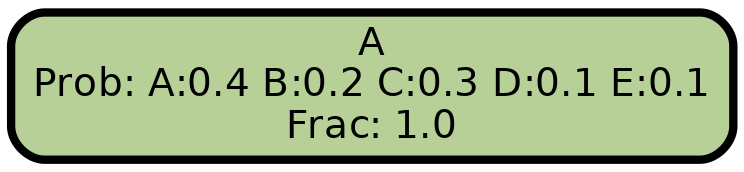

In [8]:
! ls -lhS dotfiles_1_phylum_/*png | head -n 3

from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='dotfiles_2_phylum_/Proteobacteria_5.png')

# Generate hypotheses

In [9]:
hypothesis = Hypothesis(quantizer=quantizer, model_path=outdirname, 
                        detailed_labels=True)

hypothesis.causal_constraint = -2
hypothesis.no_self_loops = False

hypothesis.get(time_start=10, time_end=20)
hypothesis.to_dot('hypothesis_phylum_10_20.dot')
hypothesis.hypotheses.sort_values('src')

100%|██████████| 16/16 [00:02<00:00,  6.91it/s]


,src,tgt,time_tgt,lomar,pvalue
42,Actinobacteriota,Actinobacteriota,18.0,0.018894,0.000000e+00
23,Actinobacteriota,Bacteroidota,19.0,0.571311,0.000000e+00
41,Actinobacteriota,Actinobacteriota,10.0,0.128850,0.000000e+00
31,Actinobacteriota,Firmicutes,13.0,-449.697167,0.000000e+00
32,Actinobacteriota,Firmicutes,10.0,0.182228,0.000000e+00
33,Actinobacteriota,Firmicutes,14.0,-0.107403,0.000000e+00
35,Actinobacteriota,Fusobacteriota,14.0,0.075099,0.000000e+00
24,Actinobacteriota,Bacteroidota,14.0,-0.270369,0.000000e+00
10,Actinobacteriota,Proteobacteria,18.0,-0.125256,0.000000e+00
12,Actinobacteriota,Verrucomicrobiota,18.0,0.988081,0.000000e+00


# Forecast microbiome evolution

In [10]:
%%time
# forecast from time SW
SW=29
qnet_orchestrator = QnetOrchestrator(quantizer)
qnet_orchestrator.load_qnet('data2_phylum_'+str(i)+'.joblib')
forecaster = Forecaster(qnet_orchestrator)
# can specify an end week or default to the max end week in the data
forecasted_ = forecaster.forecast_data(
    label_matrix, 
    start_week=SW).assign(source='forecasted')
    

CPU times: user 2min 37s, sys: 1.13 s, total: 2min 38s
Wall time: 2min 37s


In [11]:
label_matrix.shape

(44, 621)

In [12]:
#forecasted_dict[0]
DF=forecasted_
SUBJECTS=DF.subject_id.value_counts().index.values
DF

,subject_id,variable,week,value,source
0,1,Acidobacteriota,1,NaN,forecasted
1,10,Acidobacteriota,1,NaN,forecasted
2,11,Acidobacteriota,1,NaN,forecasted
3,12,Acidobacteriota,1,NaN,forecasted
4,14,Acidobacteriota,1,NaN,forecasted
...,...,...,...,...,...
27319,56,unclassified_Bacteria,88,0.000147,forecasted
27320,57,unclassified_Bacteria,88,0.000147,forecasted
27321,7,unclassified_Bacteria,88,0.000147,forecasted
27322,8,unclassified_Bacteria,88,0.000147,forecasted


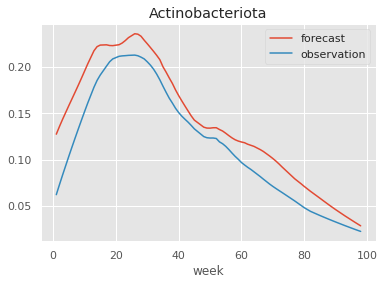

In [16]:
DF_pop=DF.groupby(['variable','week']).mean().reset_index()
DF_data=data.groupby(['variable','week']).mean().reset_index()

DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=False,alpha=.99,
                      interpolate=False,lowess_fraction=.3)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=False,alpha=.99,
                       interpolate=False,lowess_fraction=.3)


ax=DF_pop_smooth.Actinobacteriota.plot(label='forecast')
DF_data_smooth.Actinobacteriota.plot(ax=ax,label='observation')
ax.set_title('Actinobacteriota')
ax.legend();

In [17]:
data.subject_id.value_counts().index.values

array(['1', '41', '20', '33', '38', '27', '31', '43', '42', '32', '7',
       '35', '24', '25', '10', '30', '12', '44', '14', '5', '37', '18',
       '46', '16', '11', '9', '34', '8', '57', '2', '49', '45', '36',
       '21', '22', '4', '56', '55', '53', '47', '17', '52', '23', '50'],
      dtype=object)

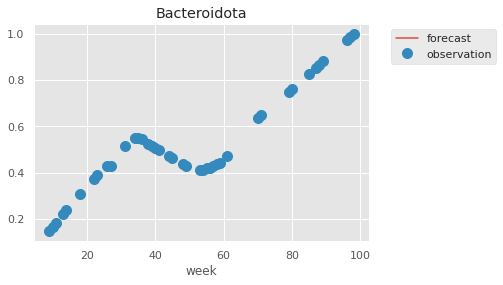

In [20]:
SID='10'
DF_pop=DF[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index()
DF_data=data[DF.subject_id==SID].groupby(['variable','week']).mean().reset_index()
DF_pop_smooth=qsmooth(DF_pop,index='week',
                      columns='variable',
                      normalize=True,alpha=.99,
                      interpolate=False,lowess_fraction=.4)

#DF_data_smooth
DF_data_smooth=qsmooth(DF_data,index='week',
                       columns='variable',
                       normalize=True,alpha=.99,
                       interpolate=False,lowess_fraction=.6)

var='Bacteroidota'
ax=DF_pop_smooth[var].plot(label='forecast')
DF_data_smooth[var].plot(ax=ax,style='o',ms=10,label='observation')
ax.set_title('Bacteroidota')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

## Forecast data for a new patient

+ Read in new data, quantize, and forecast

,week,variable,value
0,29,Firmicutes,0.346586
1,29,Actinobacteriota,0.809984
2,29,Proteobacteria,0.555777
3,29,Bacteroidota,0.569013
4,29,Verrucomicrobiota,0.375432
5,29,Desulfobacterota,0.157980
6,29,Fusobacteriota,0.394946
7,29,Campilobacterota,0.676943
8,29,Cyanobacteria,0.923957
9,29,unclassified_Bacteria,0.272099


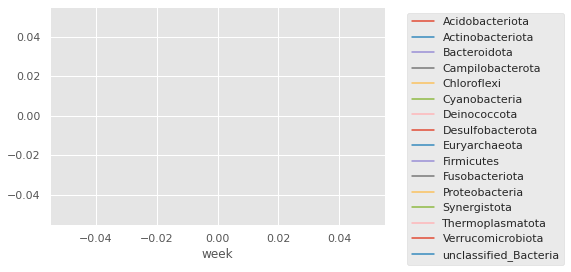

In [21]:
new_subject = pd.DataFrame({
    'week': [SW] * len(BIOMES),
    'variable': BIOMES,
    'value': np.random.rand(len(BIOMES))
})

new_subject.to_csv('example_data/single_patient_dummy/new_subject.csv',index=None)
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject.csv')
display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id=12345)
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=29, subject_id=[12345]
)

df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

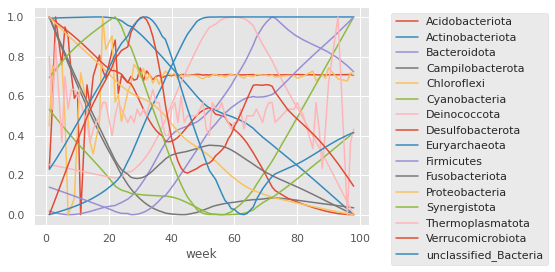

In [27]:
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject_001.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1011')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=1, subject_id=['1011']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

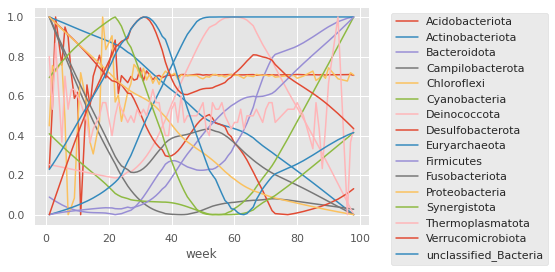

In [32]:
new_subject=pd.read_csv('example_data/single_patient_dummy/new_subject_002.csv')
#display(new_subject)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1012')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=1, subject_id=['1012']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.5,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')

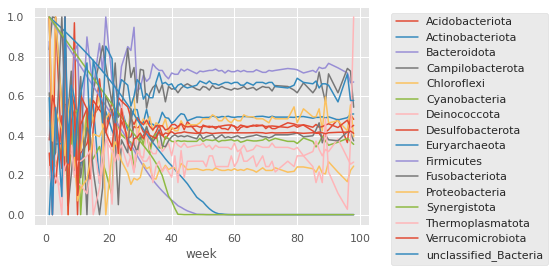

In [34]:
new_subject=data[(data.subject_id=='10') & (data.week<32)].drop('sample_id',axis=1).reset_index(drop=True)

new_subject_quantized = quantizer.quantize_new_subject(new_subject, subject_id='1013')
_, new_subject_matrix = quantizer.get_qnet_inputs(new_subject_quantized)
new_subject_forecasted = forecaster.forecast_data(
    new_subject_matrix, 
    start_week=1,end_week=20, subject_id=['1013']
)
df_=qsmooth(new_subject_forecasted.drop('subject_id',axis=1),index='week',
                    columns='variable',
                    interpolate=False,alpha=.5,
                    lowess_fraction=0.6,normalize=True)

ax=df_.plot()
ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')